In [4]:
import os
import glob
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('max_rows', 100)
pd.set_option('max_columns', 100)

perc = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]

### Speed comparison with other orders in market

#### save data

In [6]:
startTm = datetime.datetime.now()

startDate = '20201211'
endDate = '20201211'

readPath = r'\\192.168.10.28\equityTradeLogs'
dataPathLs = np.array(glob.glob(os.path.join(readPath, 'speedCompare***.csv')))
dateLs = np.array([os.path.basename(i).split('_')[1].split('.')[0] for i in dataPathLs])
dataPathLs = dataPathLs[(dateLs >= startDate) & (dateLs <= endDate)]
dateLs = dateLs[(dateLs >= startDate) & (dateLs <= endDate)]

for date in dateLs:
        
    readPath = r'\\192.168.10.28\equityTradeLogs'
    orderLog = pd.read_csv(os.path.join(readPath, 'speedCompare_%s.csv'%date))

    for col in ['clockAtArrival', 'secid', 'updateType', 'vai', 'absFilledThisUpdate', 'orderDirection', 'absOrderSize',
                'absOrderSizeCumFilled', 'date', 'accCode', 'mse']:
        orderLog[col] = orderLog[col].fillna(0)
        orderLog[col] = orderLog[col].astype('int64')

    orderLog = orderLog.sort_values(by=['date', 'secid', 'vai', 'accCode', 'clockAtArrival']).reset_index(drop=True)
    orderLog = orderLog[orderLog["secid"] >= 1000000]

    targetStock = orderLog['secid'].unique()
    targetStock = np.array([int(str(i)[1:]) for i in targetStock])
    targetStockSZ = sorted(targetStock[targetStock < 600000])
    targetStockSH = sorted(targetStock[targetStock >= 600000])
        
    readPath = '\\\\192.168.10.34\\random_backup\\Kevin_zhenyu\\rawData'
    mdOrderLogPath = glob.glob(os.path.join(readPath, 'logs_%s_zs_92_01***'%date, 'mdOrderLog***.csv'))[-1]
    mdTradeLogPath = glob.glob(os.path.join(readPath, 'logs_%s_zs_92_01***'%date, 'mdTradeLog***.csv'))[-1]
    
    mdOrderLog = pd.read_csv(mdOrderLogPath)
    mdOrderLog = mdOrderLog[mdOrderLog['SecurityID'].isin(targetStockSZ)]
    mdOrderLog['OrderType'] = mdOrderLog['OrderType'].astype(str)
    mdOrderLog = mdOrderLog[['clockAtArrival', 'sequenceNo', 'TransactTime', 'SecurityID', 'ApplSeqNum', 'Side',
                             'OrderType', 'Price', 'OrderQty']]
    
    mdTradeLog = pd.read_csv(mdTradeLogPath, encoding='utf-8')
    mdTradeLog['ExecType'] = mdTradeLog['ExecType'].astype(str)
    mdTradeLog = mdTradeLog[mdTradeLog['SecurityID'].isin(targetStockSZ)]
    mdTradeLog['volumeThisUpdate'] = np.where(mdTradeLog['ExecType'] == 'F', mdTradeLog['TradeQty'], 0)
    mdTradeLog['cum_volume'] = mdTradeLog.groupby(['SecurityID'])['volumeThisUpdate'].cumsum()
    mdTradeLog = mdTradeLog[['clockAtArrival', 'sequenceNo', 'TransactTime', 'SecurityID', 'ApplSeqNum', 'cum_volume',
                             'ExecType', 'TradePrice', 'TradeQty', 'TradeMoney', 'BidApplSeqNum', 'OfferApplSeqNum']]

    mdMsgData = pd.concat([mdOrderLog, mdTradeLog], sort=False)
    del mdOrderLog
    del mdTradeLog
    
    mdMsgData = mdMsgData.sort_values(by=['sequenceNo']).reset_index(drop=True)
    
    mdMsgData["agg_trade"] = np.where((mdMsgData["ApplSeqNum"] == mdMsgData["BidApplSeqNum"] + 1) & (mdMsgData["ExecType"] == "F"), 1, np.where(
    (mdMsgData["ApplSeqNum"] == mdMsgData["OfferApplSeqNum"] + 1) & (mdMsgData["ExecType"] == "F"), 1, 0))
    mdMsgData["agg"] = mdMsgData.groupby(["SecurityID"])["agg_trade"].shift(-1)
    mdMsgData["orderNum"] = np.where(mdMsgData["ExecType"].isnull(), 1, 0)
    mdMsgData["cumorderNum"] = mdMsgData.groupby("SecurityID")["orderNum"].cumsum()
    mdMsgData["cumorderNum2"] = np.nan
    mdMsgData.loc[mdMsgData["agg"]==1, "cumorderNum2"] = mdMsgData.loc[mdMsgData["agg"]==1, "cumorderNum"]
    mdMsgData["cumorderNum2"] = mdMsgData.groupby("SecurityID")["cumorderNum2"].ffill()
    mdMsgData.loc[mdMsgData["cumorderNum2"] == mdMsgData["cumorderNum"], "cum_volume"] = mdMsgData[mdMsgData["cumorderNum2"] == mdMsgData["cumorderNum"]]\
    .groupby(["SecurityID", "cumorderNum"])["cum_volume"].transform("max")
    
    mdMsgData = mdMsgData.sort_values(by=['sequenceNo']).reset_index(drop=True)

    mdMsgData['cum_volume'] = mdMsgData.groupby(['SecurityID'])['cum_volume'].ffill()
    mdMsgData['cum_volume'] = mdMsgData.groupby(['SecurityID'])['cum_volume'].backfill()
    mdMsgData['ExecType'] = mdMsgData['ExecType'].fillna('2')
    mdMsgData['TradeQty'] = mdMsgData['TradeQty'].fillna(0)
    
    saveCols = ['clockAtArrival', 'sequenceNo', 'TransactTime', 'SecurityID', 'cum_volume', 'ApplSeqNum', 
                'Side', 'OrderType', 'Price', 'OrderQty', 'ExecType', 'TradePrice', 'TradeQty', 'TradeMoney',
                'BidApplSeqNum', 'OfferApplSeqNum', "agg"]
    mdMsgData = mdMsgData[saveCols]
    savePath = r'L:\orderLog\mdData'
    mdMsgData.to_pickle(os.path.join(savePath, 'mdLog_msg_%s.pkl'%date))
    
print(datetime.datetime.now() - startTm)

C:\Users\win\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (55,63) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\win\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


MemoryError: 

In [3]:
startTm = datetime.datetime.now()

startDate = '20201211'
endDate = '20201211'

readPath = r'\\192.168.10.34\random_backup\Kevin_zhenyu\orderLog\equityTradeLogs'
dataPathLs = np.array(glob.glob(os.path.join(readPath, 'speedCompare***.csv')))
dateLs = np.array([os.path.basename(i).split('_')[1].split('.')[0] for i in dataPathLs])
dataPathLs = dataPathLs[(dateLs >= startDate) & (dateLs <= endDate)]
dateLs = dateLs[(dateLs >= startDate) & (dateLs <= endDate)]

for date in dateLs:
        
    readPath = r'\\192.168.10.34\random_backup\Kevin_zhenyu\orderLog\equityTradeLogs'
    orderLog = pd.read_csv(os.path.join(readPath, 'speedCompare_%s.csv'%date))

    for col in ['clockAtArrival', 'secid', 'updateType', 'vai', 'absFilledThisUpdate', 'orderDirection', 'absOrderSize',
                'absOrderSizeCumFilled', 'date', 'accCode', 'mse']:
        orderLog[col] = orderLog[col].fillna(0)
        orderLog[col] = orderLog[col].astype('int64')

    orderLog = orderLog.sort_values(by=['date', 'secid', 'vai', 'accCode', 'clockAtArrival']).reset_index(drop=True)
    orderLog = orderLog[orderLog["secid"] >= 1000000]

    targetStock = orderLog['secid'].unique()
    targetStock = np.array([int(str(i)[1:]) for i in targetStock])
    targetStockSZ = sorted(targetStock[targetStock < 600000])
    targetStockSH = sorted(targetStock[targetStock >= 600000])
        
    readPath = '\\\\192.168.10.34\\trading\\dailyRawData\\20201106\\logs_20201106_zs_88_04_day_pcap'
    mdOrderLogPath = glob.glob(readPath + '\\mdOrder***')[0]
    mdTradeLogPath = glob.glob(readPath + '\\mdTrade***')[0]
    
    mdOrderLog = pd.read_csv(mdOrderLogPath)
    mdOrderLog['SecurityID'] = np.where(mdOrderLog['ID'] > 2000000, mdOrderLog['ID'] - 2000000, mdOrderLog['ID'] - 1000000)
    mdOrderLog = mdOrderLog[mdOrderLog['SecurityID'].isin(targetStockSZ)]
    mdOrderLog['OrderType'] = mdOrderLog['OrderType'].astype(str)
    mdOrderLog = mdOrderLog.rename(columns={'time':'TransactTime'})
    mdOrderLog = mdOrderLog[['clockAtArrival', 'sequenceNo', 'TransactTime', 'SecurityID', 'ApplSeqNum', 'Side',
                             'OrderType', 'Price', 'OrderQty']]
    
    mdTradeLog = pd.read_csv(mdTradeLogPath, encoding='utf-8')
    mdTradeLog['ExecType'] = mdTradeLog['ExecType'].astype(str)
    mdTradeLog['SecurityID'] = np.where(mdTradeLog['ID'] > 2000000, mdTradeLog['ID'] - 2000000, mdTradeLog['ID'] - 1000000)
    mdTradeLog = mdTradeLog[mdTradeLog['SecurityID'].isin(targetStockSZ)]
    mdTradeLog['volumeThisUpdate'] = np.where(mdTradeLog['ExecType'] == 'F', mdTradeLog['TradeQty'], 0)
    mdTradeLog['cum_volume'] = mdTradeLog.groupby(['SecurityID'])['volumeThisUpdate'].cumsum()
    mdTradeLog = mdTradeLog.rename(columns={'time':'TransactTime'})
    mdTradeLog = mdTradeLog[['clockAtArrival', 'sequenceNo', 'TransactTime', 'SecurityID', 'ApplSeqNum', 'cum_volume',
                             'ExecType', 'TradePrice', 'TradeQty', 'TradeMoney', 'BidApplSeqNum', 'OfferApplSeqNum']]

    mdMsgData = pd.concat([mdOrderLog, mdTradeLog], sort=False)
    del mdOrderLog
    del mdTradeLog
    
    mdMsgData = mdMsgData.sort_values(by=['sequenceNo']).reset_index(drop=True)
    
    mdMsgData["agg_trade"] = np.where((mdMsgData["ApplSeqNum"] == mdMsgData["BidApplSeqNum"] + 1) & (mdMsgData["ExecType"] == "F"), 1, np.where(
    (mdMsgData["ApplSeqNum"] == mdMsgData["OfferApplSeqNum"] + 1) & (mdMsgData["ExecType"] == "F"), 1, 0))
    mdMsgData["agg"] = mdMsgData.groupby(["SecurityID"])["agg_trade"].shift(-1)
    mdMsgData["orderNum"] = np.where(mdMsgData["ExecType"].isnull(), 1, 0)
    mdMsgData["cumorderNum"] = mdMsgData.groupby("SecurityID")["orderNum"].cumsum()
    mdMsgData["cumorderNum2"] = np.nan
    mdMsgData.loc[mdMsgData["agg"]==1, "cumorderNum2"] = mdMsgData.loc[mdMsgData["agg"]==1, "cumorderNum"]
    mdMsgData["cumorderNum2"] = mdMsgData.groupby("SecurityID")["cumorderNum2"].ffill()
    mdMsgData.loc[mdMsgData["cumorderNum2"] == mdMsgData["cumorderNum"], "cum_volume"] = mdMsgData[mdMsgData["cumorderNum2"] == mdMsgData["cumorderNum"]]\
    .groupby(["SecurityID", "cumorderNum"])["cum_volume"].transform("max")
    
    mdMsgData = mdMsgData.sort_values(by=['sequenceNo']).reset_index(drop=True)

    mdMsgData['cum_volume'] = mdMsgData.groupby(['SecurityID'])['cum_volume'].ffill()
    mdMsgData['cum_volume'] = mdMsgData.groupby(['SecurityID'])['cum_volume'].backfill()
    mdMsgData['ExecType'] = mdMsgData['ExecType'].fillna('2')
    mdMsgData['TradeQty'] = mdMsgData['TradeQty'].fillna(0)
    
    saveCols = ['clockAtArrival', 'sequenceNo', 'TransactTime', 'SecurityID', 'cum_volume', 'ApplSeqNum', 
                'Side', 'OrderType', 'Price', 'OrderQty', 'ExecType', 'TradePrice', 'TradeQty', 'TradeMoney',
                'BidApplSeqNum', 'OfferApplSeqNum', "agg"]
    mdMsgData = mdMsgData[saveCols]
    savePath = r'L:\orderLog\mdData'
    mdMsgData.to_pickle(os.path.join(savePath, 'mdLog_msg1_%s.pkl'%date))
    
print(datetime.datetime.now() - startTm)

0:00:00.043882


(array([  7.,   6.,  12.,   6., 193., 504., 534., 102.,  45.,  34.,  23.,
         16.,  14.,  18.,  15.,   8.,   5.,   8.,  13.,  13.,   9.,   3.,
          2.,   0.,   0.,   2.,   0.,   1.,   0.,   3.]),
 array([1.40000e+01, 6.74900e+02, 1.33580e+03, 1.99670e+03, 2.65760e+03,
        3.31850e+03, 3.97940e+03, 4.64030e+03, 5.30120e+03, 5.96210e+03,
        6.62300e+03, 7.28390e+03, 7.94480e+03, 8.60570e+03, 9.26660e+03,
        9.92750e+03, 1.05884e+04, 1.12493e+04, 1.19102e+04, 1.25711e+04,
        1.32320e+04, 1.38929e+04, 1.45538e+04, 1.52147e+04, 1.58756e+04,
        1.65365e+04, 1.71974e+04, 1.78583e+04, 1.85192e+04, 1.91801e+04,
        1.98410e+04]),
 <a list of 30 Patch objects>)

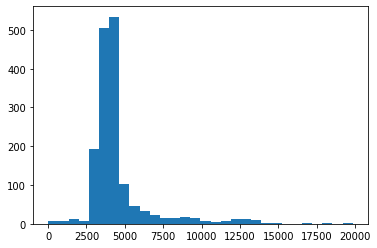

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(checkLog[(~checkLog["brokerLs"].isnull()) & (~checkLog["clockAtArrival"].isnull()) & (checkLog["startclock"] != checkLog["clockAtArrival"])]["diff"], bins=30)

In [ ]:
startTm = datetime.datetime.now()

startDate = '20201102'
endDate = '20201106'

readPath = r'\\192.168.10.34\random_backup\Kevin_zhenyu\orderLog\equityTradeLogs'
dataPathLs = np.array(glob.glob(os.path.join(readPath, 'speedCompare***.csv')))
dateLs = np.array([os.path.basename(i).split('_')[1].split('.')[0] for i in dataPathLs])
dataPathLs = dataPathLs[(dateLs >= startDate) & (dateLs <= endDate)]
dateLs = dateLs[(dateLs >= startDate) & (dateLs <= endDate)]

for thisDate in dateLs:
    
    readPath = r'\\192.168.10.34\random_backup\Kevin_zhenyu\orderLog\equityTradeLogs'
    rawOrderLog = pd.read_csv(os.path.join(readPath, 'speedCompare_%s.csv'%thisDate))
    for col in ['clockAtArrival', 'caamd', 'secid', 'updateType', 'vai', 'absFilledThisUpdate', 'orderDirection', 'absOrderSize',
                'absOrderSizeCumFilled', 'date', 'accCode', 'mse']:
        rawOrderLog[col] = rawOrderLog[col].fillna(0)
        rawOrderLog[col] = rawOrderLog[col].astype('int64')   
    rawOrderLog = rawOrderLog.sort_values(by=['date', 'secid', 'vai', 'accCode', 'clockAtArrival']).reset_index(drop=True)

    rawOrderLog = rawOrderLog[rawOrderLog["secid"] >= 1000000]

    rawOrderLog['clock'] = rawOrderLog['clockAtArrival'].apply(lambda x: datetime.datetime.fromtimestamp(x/1e6))
    rawOrderLog["broker"] = np.where(rawOrderLog["accCode"].astype(str).apply(lambda x: len(x) == 6), rawOrderLog['accCode'] // 10000, rawOrderLog['accCode'] // 100)
    rawOrderLog['colo_broker'] = rawOrderLog['colo'].str[:2] + '_' + rawOrderLog['broker'].astype('str')
    rawOrderLog['colo_account'] = rawOrderLog['colo'].str[:2] + '_' + rawOrderLog['accCode'].astype('str')
    rawOrderLog['order'] = rawOrderLog.groupby(['date', 'accCode', 'secid', 'vai']).grouper.group_info[0]
    rawOrderLog['group'] = rawOrderLog.groupby(['date', 'secid', 'vai']).grouper.group_info[0]
    rawOrderLog['startClock'] = rawOrderLog.groupby(['order'])['clockAtArrival'].transform('first')
    rawOrderLog['duration'] = rawOrderLog['clockAtArrival'] - rawOrderLog['startClock']
    rawOrderLog['orderPrice'] = rawOrderLog['orderPrice'].apply(lambda x: round(x, 2))
    rawOrderLog['tradePrice'] = rawOrderLog['tradePrice'].apply(lambda x: round(x, 2))
    rawOrderLog['orderDirection1'] = np.where(rawOrderLog["orderDirection"] == -2, -1, np.where(
        rawOrderLog["orderDirection"] == 2, 1, rawOrderLog["orderDirection"]))
    orderLog = rawOrderLog.copy()
    
    
    ### Assertion 1:  make sure same direction in same date, secid, vai
    print('=======================================================================================')
    print('1. same date, secid, vai: same direction')
    orderLog['directNum'] = orderLog.groupby(['date', 'secid', 'vai'])['orderDirection1'].transform('nunique')
    if len(orderLog[orderLog['directNum'] != 1]) > 0:
        print('opposite direction for same date, same secid, same vai')
        display(orderLog[(orderLog['directNum'] != 1) & (orderLog['updateType'] == 0)][['date', 'accCode', 'secid', 'vai', 'orderDirection', 'order']])
        orderLog = orderLog[orderLog['directNum'] == 1]

    assert((orderLog.groupby(['date', 'secid', 'vai'])['orderDirection1'].nunique() == 1).all() == True)

    ## Assertion 2:  make sure each account, secid, vai only has one insertion
    print('=======================================================================================')
    print('2. same date, secid, vai, accCode: one insertion')
    a = orderLog[orderLog['updateType'] == 0].groupby(['date', 'accCode', 'secid', 'vai', 'order'])['clockAtArrival'].count()
    if len(a[a > 1]) > 0:
        print('more than one insertion at same time')
        a = a[a>1].reset_index()
        display(a)
        orderLog = orderLog[~(orderLog['order'].isin(a['order'].unique()))]

    orderLog['isMsg'] = np.where(orderLog['updateType'] == 0, 
                                 np.where(orderLog['mse'] == 100, 1, 0), np.nan)
    orderLog['isMsg'] = orderLog.groupby(['order'])['isMsg'].ffill()

    placeSZE = orderLog[(orderLog['secid'] >= 2000000) & (orderLog['updateType'] == 0)]
    print('%.2f%% SZE orders triggered by msg data'%(placeSZE[placeSZE['isMsg'] == 1].shape[0]/placeSZE.shape[0]*100))


    ### Assertion 3:  check IPO stocks selling status
    print('=======================================================================================')
    print('3. IPO stocks selling (ars = 301, 302)')
    if orderLog[orderLog['ars'].isin([301, 302])].shape[0] != 0:
        kk = orderLog[orderLog['ars'].isin([301, 302])]
        print(kk)
        try:
            assert(kk[kk['orderDirection1'] == 1].shape[0] == 0)
            print('we only sell, never buy')
        except:
            print('There are IPO buy side orders!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
            print(kk[kk['orderDirection1'] == 1])
        kk1 = kk[kk['updateType'] == 0]
        kk1 = kk1.sort_values(by=['accCode', 'secid','clockAtArrival'])
        kk1['diff'] = kk1.groupby(['accCode', 'secid'])['clockAtArrival'].apply(lambda x: x-x.shift(1))
        kk1['diff'] = kk1['diff'].fillna(0)
        try:
            assert(kk1[kk1['diff'] < 10e6].shape[0] == 0)
            print('for each stock in the same account, there is no insertion within 10 seconds of the previous insertion')
        except:
            print('There are insertion within 10 seconds for orders under same account same stock!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
            print(kk1[kk1['diff'] < 10e6])
        kk2 = kk[(kk['updateType'] == 1)]
        try:
            assert(kk2[kk2['duration'] < 3e6].shape[0] == 0)
            print('for each stock in the same account, the cancellation of an order happens more than 3 seconds after the insertion')
        except:
            print('There are cancellation within 3 seconds for orders under same account same stock!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
            print(kk2[kk2['duration'] < 3e6])


    ### Assertion 4: check updateType == 7 orders, make sure updateType == 7 orders < 20 per account, < 100 in total
    print('=======================================================================================')
    print('4. updateType 7 orders')
    if orderLog[orderLog['updateType'] == 7].shape[0] != 0:
        assert(orderLog[orderLog['updateType'] == 7].groupby('accCode')['order'].nunique().max() < 20)
        assert(orderLog[orderLog['updateType'] == 7].groupby('accCode')['order'].nunique().sum() < 100)

    ### Assertion 5: check updateType == 6 orders, make sure updateType == 6 orders < 5% per account
    print('=======================================================================================')
    print('5. updateType 6 orders')
    k1 = orderLog[orderLog['updateType'] == 6].groupby('accCode')['order'].nunique().reset_index()
    k2 = orderLog.groupby('accCode')['order'].nunique().reset_index()
    k = pd.merge(k1, k2, on='accCode', how='left')
    k['prob'] = k['order_x']/k['order_y']
    try:
        assert(sum(k['prob'] >= 0.05) == 0)
    except:
        print('There are accounts with more than 5% updateType 6 orders!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
        print(k[k['prob'] >= 0.05])

    ### Assertion 6: check CYB orders, make sure CYB stocks total absOrderSize < 30w
    print('=======================================================================================')
    print('6. CYB stocks total order size < 30w')
    try:
        assert(orderLog[(orderLog['secid'] >= 2300000) & (orderLog['updateType'] == 0)]['absOrderSize'].max() <= 300000)
    except:
        print('CYB stocks total absOrderSize >= 30w!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')


    ### Assertion 7:  make sure there is no unexpected updateType 
    print('=======================================================================================')
    print('7. unexpected updateType')
    def getTuple(x):
        return tuple(i for i in x)

    checkLog = orderLog[~((orderLog['updateType'] == 4) & (orderLog.groupby(['order'])['updateType'].shift(-1) == 4))]
    checkLog = checkLog.groupby(['order'])['updateType'].apply(lambda x: getTuple(x)).reset_index()
    checkLog['status'] = np.where(checkLog['updateType'].isin([(0, 2, 4), (0, 2, 1, 4), (0, 2, 1, 2, 4), (0, 2, 4, 1, 4), (0, 4), (0, 1, 4), (0, 4, 1, 4), (0, 2, 2, 4), (0, 4, 2, 4), (0, 2, 2, 1, 4), (0, 2, 2, 4, 1, 4)]),0,
                         np.where(checkLog['updateType'].isin([(0, 2, 4, 1, 3), (0, 2, 4, 1, 4, 3), (0, 2, 1, 4, 3), (0, 4, 1, 3), (0, 1, 4, 3),
                                                                   (0, 2, 2, 4, 1, 3), (0, 2, 2, 4, 1, 4, 3), (0, 2, 2, 1, 4, 3), (0, 4, 2, 4, 1, 3),
                                                                   (0, 4, 2, 1, 3), (0, 4, 1, 4, 3), (0, 4, 1)]), 1,
                         np.where(checkLog['updateType'].isin([(0, 2, 1, 3), (0, 2, 2, 1, 3), (0, 2, 3), (0, 3), (0, 1, 3), (0, ), (0, 2), (0, 2, 1), (0, 2, 2)]), 2, 3)))

    orderLog = pd.merge(orderLog, checkLog[['order', 'status']], how='left', on=['order'], validate='many_to_one')
    orderLog = orderLog[orderLog['status'].isin([0, 1, 2])].reset_index(drop=True)

    ### Assertion 8:  make sure status==0 got all traded
    print('=======================================================================================')
    print('8. status == 0: all traded')
    a = orderLog[orderLog['status'] == 0]
    a = a.groupby(['order'])[['absOrderSizeCumFilled', 'absOrderSize']].max().reset_index()
    a.columns = ['order', 'filled', 'total']
    print('in total trade, any fill != total cases')
    display(a[a['filled'] != a['total']])
    if a[a['filled'] != a['total']].shape[0] > 0:
        removeOrderLs = a[a['filled'] != a['total']]['order'].unique()
        orderLog = orderLog[~(orderLog['order'].isin(removeOrderLs))]

    ### Assertion 9:  make sure status==1 got partial traded
    print('=======================================================================================')
    print('9. status == 1: partial traded')
    a = orderLog[orderLog['status'] == 1]
    a = a.groupby(['order'])[['absOrderSizeCumFilled', 'absOrderSize']].max().reset_index()
    a.columns = ['order', 'filled', 'total']
    print('in partial trade, any fill >= total or fill is 0 cases for updateType 4')
    display(a[(a['filled'] >= a['total']) | (a['filled'] == 0)])
    if a[(a['filled'] >= a['total']) | (a['filled'] == 0)].shape[0] > 0:
        removeOrderLs = a[(a['filled'] >= a['total']) | (a['filled'] == 0)]['order'].unique()
        orderLog = orderLog[~(orderLog['order'].isin(removeOrderLs))]

    ### Assertion 10: make sure no cancellation within 1 sec
    print('=======================================================================================')
    print('10. no cancellation within 1 sec')
    a = orderLog[(orderLog['updateType'] == 1) & (orderLog['duration'] < 1e6)]
    print('any cancellation within 1 sec')
    display(a)
    if a.shape[0] > 0:
        removeOrderLs = a['order'].unique()
        orderLog = orderLog[~(orderLog['order'].isin(removeOrderLs))]


    ### Assertion 11: make sure no order has shares > 80w or notional > 800w
    print('=======================================================================================')
    print('11. Orders with size > 80w or notional > 800w')
    orderLog['orderNtl'] = orderLog['absOrderSize'] * orderLog['orderPrice']
    if orderLog[orderLog['absOrderSize'] > 800000].shape[0] > 0:
        print('some order quantity are > 80w')
        print(orderLog[orderLog['absOrderSize'] > 800000].groupby(['colo', 'accCode'])['order'].nunique())
        display(orderLog[orderLog['absOrderSize'] > 800000][['date', 'accCode', 'secid', 'vai', 'absOrderSize', 'orderPrice',
                                                             'orderNtl', 'orderDirection', 'clock', 'order']])

    if orderLog[orderLog['orderNtl'] > 8000000].shape[0] > 0:
        print('some order ntl are > 800w')
        print(orderLog[orderLog['orderNtl'] > 8000000].groupby(['colo', 'accCode'])['order'].nunique())
        display(orderLog[orderLog['orderNtl'] > 8000000][['date', 'accCode', 'secid', 'vai', 'absOrderSize', 'orderPrice',
                                                          'orderNtl', 'orderDirection', 'clock', 'order', "updateType", 
                                                          "tradePrice", "absOrderSizeCumFilled", "absFilledThisUpdate"]])

    removeOrderLs = list(set(orderLog[orderLog['absOrderSize'] > 800000]['order'].unique()) | set(orderLog[orderLog['orderNtl'] > 8000000]['order'].unique()))
    orderLog = orderLog[~(orderLog['order'].isin(removeOrderLs))]

    orderLog = orderLog.sort_values(by=['date', 'secid', 'vai', 'accCode', 'clockAtArrival']).reset_index(drop=True)

    orderLog['exchange'] = np.where(orderLog['secid'] >= 2000000, 'SZE', 'SSE')
    orderLog['orderNtl'] = orderLog['orderPrice'] * orderLog['absOrderSize']
    orderLog['tradeNtl'] = np.where(orderLog['updateType'] == 4, orderLog['tradePrice']*orderLog['absFilledThisUpdate'], 0)
    orderLog = orderLog[orderLog['secid'] >= 2000000].reset_index(drop=True)
    
    readPath = r'L:\orderLog\mdData'
    rawMsgDataSZ = pd.read_pickle(os.path.join(readPath, 'mdLog_msg_%s.pkl'%thisDate))
    orderDataSZ = rawMsgDataSZ[rawMsgDataSZ['ExecType'] == '2'][['SecurityID', 'ApplSeqNum', 'clockAtArrival', 'sequenceNo', 'Side', 'OrderQty', 'Price', 'cum_volume', "agg", "TransactTime"]].reset_index(drop=True)
    orderDataSZ['updateType'] = 0
    tradeDataSZ = pd.concat([rawMsgDataSZ[rawMsgDataSZ['ExecType'] == 'F'][['SecurityID', 'BidApplSeqNum', 'clockAtArrival', 'sequenceNo', 'TradePrice', 'TradeQty', 'cum_volume', "TransactTime"]],
                             rawMsgDataSZ[rawMsgDataSZ['ExecType'] == 'F'][['SecurityID', 'OfferApplSeqNum', 'clockAtArrival', 'sequenceNo', 'TradePrice', 'TradeQty', 'cum_volume', "TransactTime"]]], sort=False)
    tradeDataSZ['ApplSeqNum'] = np.where(tradeDataSZ['BidApplSeqNum'].isnull(), tradeDataSZ['OfferApplSeqNum'], tradeDataSZ['BidApplSeqNum'])
    tradeDataSZ['Side'] = np.where(tradeDataSZ['BidApplSeqNum'].isnull(), 2, 1)
    tradeDataSZ = tradeDataSZ[['SecurityID', 'ApplSeqNum', 'clockAtArrival', 'sequenceNo', 'Side', 'TradePrice', 'TradeQty', 'cum_volume', "TransactTime"]]
    tradeDataSZ['updateType'] = 4
    cancelDataSZ = rawMsgDataSZ[rawMsgDataSZ['ExecType'] == '4'][['SecurityID', 'BidApplSeqNum', 'OfferApplSeqNum', 'clockAtArrival', 'sequenceNo', 'TradePrice', 'TradeQty', 'cum_volume', "TransactTime"]].reset_index(drop=True)
    cancelDataSZ['ApplSeqNum'] = np.where(cancelDataSZ['BidApplSeqNum'] == 0, cancelDataSZ['OfferApplSeqNum'], cancelDataSZ['BidApplSeqNum'])
    cancelDataSZ['Side'] = np.where(cancelDataSZ['BidApplSeqNum'] == 0, 2, 1)
    cancelDataSZ = cancelDataSZ[['SecurityID', 'ApplSeqNum', 'clockAtArrival', 'sequenceNo', 'Side', 'TradeQty', 'cum_volume', "TransactTime"]]
    cancelDataSZ['updateType'] = 3

    msgDataSZ = pd.concat([orderDataSZ, tradeDataSZ, cancelDataSZ], sort=False)
    del orderDataSZ
    del tradeDataSZ
    del cancelDataSZ
    msgDataSZ = msgDataSZ.sort_values(by=['SecurityID', 'ApplSeqNum', 'sequenceNo']).reset_index(drop=True)
    
    msgDataSZ['TradePrice'] = np.where(msgDataSZ['updateType'] == 4, msgDataSZ['TradePrice'], 0)
    msgDataSZ['TradePrice'] = msgDataSZ['TradePrice'].astype('int64')
    msgDataSZ['TradeQty'] = np.where(msgDataSZ['updateType'] == 4, msgDataSZ['TradeQty'], 0)
    msgDataSZ['TradeQty'] = msgDataSZ['TradeQty'].astype('int64')
    msgDataSZ['secid'] = msgDataSZ['SecurityID'] + 2000000
    assert(msgDataSZ['ApplSeqNum'].max() < 1e8)
    msgDataSZ['StockSeqNum'] = msgDataSZ['SecurityID']*1e8 + msgDataSZ['ApplSeqNum']
    msgDataSZ['date'] = int(thisDate)
    msgDataSZ['startVolume'] = msgDataSZ.groupby(['StockSeqNum'])['cum_volume'].transform('first')
            
    ### order insertion position
    startPos = orderLog[(orderLog['date'] == int(thisDate)) & (orderLog['updateType'] == 0) & (orderLog['secid'] >= 2000000) & (orderLog["isMsg"] == 1)]
    # here!!!!!!!!!! drop duplicates
    startPos = startPos.drop_duplicates(subset=['date', 'secid', 'vai'])
    
    startPos = startPos[((startPos.clock.dt.time >= datetime.time(9, 33)) & (startPos.clock.dt.time <= datetime.time(11, 30))) |\
                        ((startPos.clock.dt.time >= datetime.time(13, 3)) & (startPos.clock.dt.time <= datetime.time(14, 55)))]
#     startPos = startPos[startPos.clock.dt.time < datetime.time(9, 33)]
    
    startPos['SecurityID'] = startPos['secid']-2000000
    startPos['orderDirection1'] = np.where(startPos['orderDirection1'] == 1, 1, 2)
    startPos['cum_volume'] = startPos['vai']
    startPos = startPos[['SecurityID', 'cum_volume', 'orderDirection1', 'accCode', 'absOrderSize', 'vai', 'group']]
    startPos['stockGroup'] = startPos.groupby(['accCode', 'SecurityID']).grouper.group_info[0]
    startPos = startPos.sort_values(by=['SecurityID', 'cum_volume']).reset_index(drop=True)

    
    ### generate order status change data
    infoData = orderLog[(orderLog['date'] == int(thisDate)) & (orderLog['group'].isin(startPos['group'].unique())) & (orderLog['updateType'].isin([0, 3, 4]))].reset_index(drop=True)
    infoData['Price'] = infoData['orderPrice'].apply(lambda x: round(x*100, 0))
    infoData['Price'] = infoData['Price'].astype('int64')*100
    infoData['OrderQty'] = infoData['absOrderSize']
    infoData['Side'] = np.where(infoData['orderDirection1'] == 1, 1, 2)
    infoData['TradePrice'] = np.where(infoData['updateType'] == 4, round(infoData['tradePrice']*100, 0), 0)
    infoData['TradePrice'] = infoData['TradePrice'].astype('int64')*100
    statusInfo = infoData.groupby(['order'])['updateType'].apply(lambda x: tuple(x)).reset_index()
    statusInfo.columns = ['order', 'statusLs']
    tradePriceInfo = infoData.groupby(['order'])['TradePrice'].apply(lambda x: tuple(x)).reset_index()
    tradePriceInfo.columns = ['order', 'TradePriceLs']
    tradeQtyInfo = infoData.groupby(['order'])['absFilledThisUpdate'].apply(lambda x: tuple(x)).reset_index()
    tradeQtyInfo.columns = ['order', 'TradeQtyLs']
    infoData["abstradeNtl"] = infoData["absFilledThisUpdate"] * infoData["TradePrice"]
    infoData["TradeNtl"] = infoData.groupby(['order'])['abstradeNtl'].transform('sum')
    infoData = infoData[infoData['updateType'] == 0]
    infoData = pd.merge(infoData, statusInfo, how='left', on=['order'], validate='one_to_one')
    infoData = pd.merge(infoData, tradePriceInfo, how='left', on=['order'], validate='one_to_one')
    infoData = pd.merge(infoData, tradeQtyInfo, how='left', on=['order'], validate='one_to_one')
    infoData['brokerNum'] = infoData.groupby(['date', 'secid', 'vai', 'Price', 'OrderQty', 'Side', 'statusLs', 'TradePriceLs', 'TradeQtyLs'])['colo_account'].transform('count')
    infoData['brokerLs'] = infoData.groupby(['date', 'secid', 'vai', 'Price', 'OrderQty', 'Side', 'statusLs', 'TradePriceLs', 'TradeQtyLs'])['colo_account'].transform(lambda x: ','.join(sorted(x.unique())))
    display(infoData[(infoData["brokerNum"] >= 2) & (infoData["orderDirection"].isin([-2, 2]))]["group"].nunique())
    display(infoData[(infoData["brokerNum"] < 2) & (infoData["orderDirection"].isin([-2, 2]))]["group"].nunique())
    display(infoData[(infoData["brokerNum"] >= 2) & (infoData["orderDirection"].isin([-2, 2]))]["group"].unique())
    gl = infoData[(infoData["brokerNum"] >= 2) & (infoData["orderDirection"].isin([-2, 2]))]["group"].unique()
    gl1 = infoData["group"].unique()
    print(len(gl1))
    print(len(startPos["group"].unique()))
    infoData = infoData.drop_duplicates(subset=['date', 'secid', 'vai', 'Price', 'OrderQty', 'Side', 'statusLs', 'TradePriceLs', 'TradeQtyLs']).reset_index(drop=True)
    infoData = infoData[['date', 'secid', 'vai', 'ars', "mrstaat", "mrstauc", 'isMsg', 'TradeNtl', 'exchange', 'group', 'Price', 'OrderQty', 'Side', 'statusLs', 'TradePriceLs', 'TradeQtyLs', 'brokerNum', 'brokerLs', 'order']]
    
    ### find all orders in market that inserted with us
    checkLog = msgDataSZ[msgDataSZ['updateType'] == 0][['StockSeqNum', 'SecurityID', 'cum_volume', 'sequenceNo', 'clockAtArrival', 'Side', 'OrderQty', 'Price', "agg", "TransactTime"]].reset_index(drop=True)
    checkLog = checkLog.sort_values(by=['SecurityID', 'sequenceNo'])
    checkLog = pd.merge(checkLog, startPos, how='outer', on=['SecurityID', 'cum_volume'], validate='many_to_one')
#     del startPos
    if checkLog[(~checkLog['vai'].isnull()) & (checkLog['clockAtArrival'].isnull())].shape[0] > 0:
        print('some order vai are wrong')
        removeGroup = checkLog[(~checkLog['vai'].isnull()) & (checkLog['clockAtArrival'].isnull())]['stockGroup'].unique()
        print(removeGroup)
        print(len(gl1))
        print(len(set(checkLog["group"].unique())))
        checkLog = checkLog[~checkLog['stockGroup'].isin(removeGroup)].reset_index(drop=True)
        display(len(set(gl1) - set(checkLog["group"].unique())))
    
    assert(checkLog[(~checkLog['vai'].isnull()) & (checkLog['clockAtArrival'].isnull())].shape[0] == 0)
    checkLog['lastClockInVol'] = checkLog.groupby(['SecurityID', 'cum_volume'])['clockAtArrival'].transform('last')
    checkLog['startClock'] = np.where((~checkLog['group'].isnull()) & (checkLog['clockAtArrival'] == checkLog['lastClockInVol']),
                                      checkLog['clockAtArrival'], np.nan)
    checkLog['group'] = checkLog['group'].ffill()
    checkLog['startClock'] = checkLog.groupby(['SecurityID', 'group'])['startClock'].transform('max')
    checkLog['endClock'] = checkLog['startClock'] + 20*1e3
    checkLog = pd.concat([checkLog[checkLog['clockAtArrival'] == checkLog['startClock']], 
                          checkLog[(checkLog['clockAtArrival'] > checkLog['startClock'] + 10) & 
                                   (checkLog['clockAtArrival'] <= checkLog['endClock'])]])
    checkLog = checkLog.sort_values(by=['SecurityID', 'group'])
    checkLog['vai'] = checkLog.groupby(['SecurityID', 'group'])['vai'].ffill()
    checkLog['orderDirection1'] = checkLog.groupby(['SecurityID', 'group'])['orderDirection1'].ffill()
    checkLog = pd.concat([checkLog[checkLog['clockAtArrival'] == checkLog['startClock']],
                         checkLog[(checkLog['Side'] == checkLog['orderDirection1']) & (checkLog['clockAtArrival'] != checkLog['startClock'])]]).sort_values(by=['SecurityID', 'group'])
     
    group_list = checkLog["group"].unique()

    
    checkLog = pd.merge(msgDataSZ, checkLog[['StockSeqNum', 'vai', 'group']], how='left', on=['StockSeqNum'], validate='many_to_one')
    del msgDataSZ
    checkLog = checkLog[~checkLog['group'].isnull()]
    # 上面能不能简化成inner merge!!!!!!!!!!!!!!!!!!!!!!!!!
    statusInfo = checkLog.groupby(['StockSeqNum'])['updateType'].apply(lambda x: getTuple(x)).reset_index()
    statusInfo.columns = ['StockSeqNum', 'statusLs']
    tradePriceInfo = checkLog.groupby(['StockSeqNum'])['TradePrice'].apply(lambda x: tuple(x)).reset_index()
    tradePriceInfo.columns = ['StockSeqNum', 'TradePriceLs']
    tradeQtyInfo = checkLog.groupby(['StockSeqNum'])['TradeQty'].apply(lambda x: tuple(x)).reset_index()
    tradeQtyInfo.columns = ['StockSeqNum', 'TradeQtyLs']
    checkLog = checkLog[checkLog['updateType'] == 0]
    checkLog = pd.merge(checkLog, statusInfo, how='left', on=['StockSeqNum'], validate='one_to_one')
    checkLog = pd.merge(checkLog, tradePriceInfo, how='left', on=['StockSeqNum'], validate='one_to_one')
    checkLog = pd.merge(checkLog, tradeQtyInfo, how='left', on=['StockSeqNum'], validate='one_to_one')
    
    infoData = infoData[infoData["group"].isin(group_list)]

    
    checkLog = pd.merge(checkLog, infoData, how='outer', on=['date', 'secid', 'group', 'vai', 'Price', 'OrderQty', 'Side', 'statusLs', 'TradePriceLs', 'TradeQtyLs'], validate='many_to_one')
    display(set(gl) & set(checkLog["group"].unique()))
    display(len(set(gl1) & set(checkLog["group"].unique())))
    checkLog = checkLog.sort_values(by=['date', 'secid', 'vai', 'sequenceNo']).reset_index(drop=True)
    ### orderType 1 orders have 0 order price, replace 0 with group price
    checkLog['groupPrice'] = checkLog.groupby(['group'])['Price'].transform('median')
    checkLog['Price'] = np.where(checkLog['Price'] == 0, checkLog['groupPrice'], checkLog['Price'])
    checkLog['OrderNtl'] = checkLog['Price'] * checkLog['OrderQty'] / 10000
    
    savePath = r'L:\orderLog\result\marketPos'
    checkLog.reset_index(drop=True).to_pickle(os.path.join(savePath, 'marketPos1_%s.pkl'%thisDate))
    
print(datetime.datetime.now() - startTm)

1. same date, secid, vai: same direction
opposite direction for same date, same secid, same vai


,date,accCode,secid,vai,orderDirection,order
5971,20201102,5328,1600050,-1,2,80861
5975,20201102,5328,1600050,-1,2,80861
5978,20201102,5328,1600050,-1,1,80861
5981,20201102,5328,1600050,-1,-2,80861
6765,20201102,6237,1600053,874196,-1,96348
...,...,...,...,...,...,...
1149540,20201102,5456,2300788,888179,1,91784
1163987,20201102,5275,2300815,41900,1,59649
1163991,20201102,5456,2300815,41900,-1,91807
1164009,20201102,5275,2300815,73300,-1,59654


2. same date, secid, vai, accCode: one insertion
more than one insertion at same time


,date,accCode,secid,vai,order,clockAtArrival
0,20201102,5222,2000526,511315,232,2
1,20201102,5226,2000526,511315,15832,2
2,20201102,5275,2002095,1840594,50778,3
3,20201102,5275,2002291,490300,51260,2
4,20201102,5275,2002832,6179485,53115,2
5,20201102,5275,2002833,80000,53136,2
6,20201102,5275,2002833,1461690,53200,2
7,20201102,5275,2002912,54868,53453,2
8,20201102,5275,2002912,824579,53455,2
9,20201102,5275,2002947,1700,53595,2


99.82% SZE orders triggered by msg data
3. IPO stocks selling (ars = 301, 302)
4. updateType 7 orders
5. updateType 6 orders
6. CYB stocks total order size < 30w
7. unexpected updateType
8. status == 0: all traded
in total trade, any fill != total cases


,order,filled,total
19854,28065,1500,7000
28501,40470,9300,11600
37067,52579,4000,5700
38601,54970,1300,3400
59418,82636,1200,2400
63213,89470,3981,4300
66507,94605,200,1900
77975,111945,400,1400
95483,133404,1400,1500
99892,139897,4500,11100


9. status == 1: partial traded
in partial trade, any fill >= total or fill is 0 cases for updateType 4


,order,filled,total


10. no cancellation within 1 sec
any cancellation within 1 sec


,Unnamed: 0,date,clockAtArrival,caamd,colo,accCode,secid,vai,sdd,orderDirection,absOrderSize,updateType,tradePrice,absFilledThisUpdate,absOrderSizeCumFilled,tradeId,orderSysId,aaa,internalId,ars,mse,mta,sequenceNo,mrstauc,mrss300,cfe,finalState,ApplSeqNum,mra100,mrstaat,hee,mt,session,ms,mrb100,mrsb90,orderPrice,threadId,mrsb300,clock,mrss90,underlyingIndex,mrm,l4tr,orderId,mfe,cancellationPending,mrstaum,broker,colo_broker,colo_account,order,group,startClock,duration,orderDirection1,directNum,isMsg,status


11. Orders with size > 80w or notional > 800w


711

2546

array([ 51274,  51283,  51802,  51803,  51804,  51920,  51926,  51928,
        51929,  51932,  51940,  51941,  51942,  52016,  52521,  52563,
        52765,  52774,  52844,  52857,  52889,  52891,  52905,  53078,
        53303,  53565,  53566,  53576,  53582,  53583,  53585,  53689,
        53694,  53732,  53748,  53772,  53773,  53774,  53775,  53776,
        53777,  53778,  54154,  54305,  54306,  54308,  54749,  54764,
        54765,  54770,  54841,  54845,  54846,  54847,  54850,  54851,
        54855,  54858,  54860,  54862,  54866,  54868,  54877,  54882,
        54883,  54886,  54888,  54889,  54893,  54899,  55203,  55206,
        55207,  55208,  55213,  55214,  55281,  56032,  56034,  56036,
        56066,  56100,  56306,  57256,  57268,  57324,  57330,  57334,
        57475,  57891,  57893,  57898,  58015,  58321,  58332,  58336,
        58807,  59029,  59351,  59568,  59932,  59933,  59934,  59935,
        59939,  59941,  59946,  59947,  59948,  59949,  59951,  59952,
      

90366
90366
some order vai are wrong
[6934.]
90366
90367


11

{51274,
 51283,
 51802,
 51803,
 51804,
 51920,
 51926,
 51928,
 51929,
 51932,
 51940,
 51941,
 51942,
 52016,
 52521,
 52563,
 52765,
 52774,
 52844,
 52857,
 52889,
 52891,
 52905,
 53078,
 53303,
 53565,
 53566,
 53576,
 53582,
 53583,
 53585,
 53689,
 53694,
 53732,
 53748,
 53772,
 53773,
 53774,
 53775,
 53776,
 53777,
 53778,
 54154,
 54305,
 54306,
 54308,
 54749,
 54764,
 54765,
 54770,
 54841,
 54845,
 54846,
 54847,
 54850,
 54851,
 54855,
 54858,
 54860,
 54862,
 54866,
 54868,
 54877,
 54882,
 54883,
 54886,
 54888,
 54889,
 54893,
 54899,
 55203,
 55206,
 55207,
 55208,
 55213,
 55214,
 55281,
 56032,
 56034,
 56036,
 56066,
 56100,
 56306,
 57256,
 57268,
 57324,
 57330,
 57334,
 57475,
 57891,
 57893,
 57898,
 58015,
 58321,
 58332,
 58336,
 58807,
 59029,
 59351,
 59568,
 59932,
 59933,
 59934,
 59935,
 59939,
 59941,
 59946,
 59947,
 59948,
 59949,
 59951,
 59952,
 59953,
 59957,
 59958,
 59959,
 59968,
 60852,
 61338,
 61344,
 61345,
 61393,
 61417,
 61443,
 61454,


90355

C:\Users\win\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1. same date, secid, vai: same direction
opposite direction for same date, same secid, same vai


,date,accCode,secid,vai,orderDirection,order
17744,20201103,6237,1600132,386201,1,74037
17748,20201103,6282,1600132,386201,-1,75417
17874,20201103,6237,1600132,437801,1,74051
17878,20201103,6282,1600132,437801,-1,75430
18522,20201103,6237,1600132,1456103,1,74070
...,...,...,...,...,...,...
894569,20201103,5275,2300755,2269734,1,45474
894573,20201103,5275,2300755,2269734,-1,45474
894577,20201103,9758,2300755,2269734,1,162115
919234,20201103,5275,2300815,119700,1,45755


2. same date, secid, vai, accCode: one insertion
more than one insertion at same time


,date,accCode,secid,vai,order,clockAtArrival
0,20201103,5275,2002095,1205845,41028,2
1,20201103,5275,2002727,9843398,42099,2
2,20201103,5275,2002833,6900,42397,2
3,20201103,5275,2002947,15303,42577,2
4,20201103,5275,2300573,623010,44401,2
5,20201103,5275,2300725,446324,45232,2
6,20201103,5275,2300725,820424,45251,2
7,20201103,5275,2300747,107400,45335,2
8,20201103,5275,2300747,2163071,45353,2
9,20201103,5275,2300788,192700,45635,2


99.59% SZE orders triggered by msg data
3. IPO stocks selling (ars = 301, 302)
4. updateType 7 orders
5. updateType 6 orders
6. CYB stocks total order size < 30w
7. unexpected updateType
8. status == 0: all traded
in total trade, any fill != total cases


,order,filled,total
4539,7327,2300,6400
11026,15679,2600,30200
16949,23195,1900,2500
17426,23849,2800,24100
30452,42754,2059,5300
31433,44203,600,1000
40712,56202,10600,21800
41001,56599,4200,13100
48353,67191,23,7200
59902,84716,2300,3000


9. status == 1: partial traded
in partial trade, any fill >= total or fill is 0 cases for updateType 4


,order,filled,total


10. no cancellation within 1 sec
any cancellation within 1 sec


,Unnamed: 0,date,clockAtArrival,caamd,colo,accCode,secid,vai,sdd,orderDirection,absOrderSize,updateType,tradePrice,absFilledThisUpdate,absOrderSizeCumFilled,tradeId,orderSysId,aaa,internalId,ars,mse,underlyingIndex,mrstaum,hee,mt,mrstauc,mrsb300,session,sequenceNo,l4tr,mrb100,clock,cancellationPending,cfe,orderPrice,finalState,mrm,orderId,mrss90,ms,threadId,mfe,mrstaat,ApplSeqNum,mrss300,mrsb90,mra100,mta,broker,colo_broker,colo_account,order,group,startClock,duration,orderDirection1,directNum,isMsg,status


11. Orders with size > 80w or notional > 800w


622

2878

array([ 40008,  40278,  40281,  40665,  40704,  41406,  41407,  41408,
        41409,  41410,  41411,  41416,  41443,  41474,  41529,  41532,
        41533,  41540,  41856,  41873,  41879,  41904,  42025,  42045,
        42050,  42052,  42053,  42054,  42057,  42115,  42249,  42273,
        42561,  42562,  42572,  42573,  42574,  43021,  43031,  43032,
        43047,  43071,  43076,  43078,  43126,  43127,  43128,  43129,
        43154,  43170,  43183,  43475,  43477,  43535,  43675,  43681,
        43686,  43688,  43692,  43702,  43703,  43707,  43844,  44088,
        44105,  44107,  44224,  44403,  44404,  44405,  44410,  44412,
        44414,  44417,  44422,  44424,  44425,  44724,  44794,  44951,
        44957,  44960,  44961,  44964,  44966,  44979,  44988,  45005,
        45042,  45057,  45061,  45070,  45072,  45077,  45078,  45079,
        45823,  46166,  46169,  46174,  46175,  46178,  46182,  46184,
        46451,  46590,  46664,  46669,  46675,  46677,  46678,  46680,
      

70464
70464
some order vai are wrong
[ 9420. 10519.  4056. ...  9268.  7329.  9144.]
70464
70465


58981

{42561,
 42562,
 42572,
 42573,
 42574,
 43126,
 43129,
 43154,
 43170,
 44088,
 44107,
 44403,
 44404,
 44405,
 44410,
 44412,
 44414,
 44417,
 44424,
 44425,
 46169,
 46174,
 46175,
 46178,
 46184,
 48852,
 48862,
 48863,
 48865,
 48867,
 49447,
 50106,
 50110,
 50661,
 51707,
 52202,
 52207,
 53194,
 54602,
 55735,
 55736,
 55892,
 55901,
 55908,
 56975,
 56980,
 58037,
 58044,
 59893,
 61101,
 61103,
 61115,
 61462,
 61480,
 62548,
 62745,
 63001,
 63006,
 63008,
 63011,
 63162,
 64839,
 65032,
 65033,
 65035,
 68405,
 68410,
 68411,
 68412,
 68413,
 68414,
 68415,
 68549,
 68558,
 76923,
 76925,
 76948,
 76955,
 76957,
 76959,
 77004,
 79265,
 94047,
 94056,
 94057,
 94068,
 94071,
 98493}

11483

C:\Users\win\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1. same date, secid, vai: same direction
opposite direction for same date, same secid, same vai


,date,accCode,secid,vai,orderDirection,order
93646,20201104,6237,1600648,3601386,1,83825
93650,20201104,6282,1600648,3601386,-1,85803
172253,20201104,6237,1601869,799986,-1,83906
172257,20201104,6282,1601869,799986,-1,85872
172261,20201104,9441,1601869,799986,1,137279
...,...,...,...,...,...,...
960367,20201104,9758,2300800,666600,-1,179992
960371,20201104,5275,2300800,690000,-1,51521
960375,20201104,5275,2300800,690000,-1,51521
960380,20201104,9758,2300800,690000,-1,179993


2. same date, secid, vai, accCode: one insertion
more than one insertion at same time


,date,accCode,secid,vai,order,clockAtArrival
0,20201104,5275,2002597,4500846,45759,2
1,20201104,5275,2002947,1300,46603,2
2,20201104,5275,2002947,4100,46606,3
3,20201104,5275,2002947,31500,46610,2
4,20201104,5275,2002947,70100,46612,2
5,20201104,5275,2002947,110100,46614,2
6,20201104,5275,2300233,1660364,47912,2
7,20201104,5275,2300559,962000,49435,2
8,20201104,5275,2300570,1062500,49484,2
9,20201104,5275,2300570,1461400,49498,2


99.78% SZE orders triggered by msg data
3. IPO stocks selling (ars = 301, 302)
4. updateType 7 orders
5. updateType 6 orders
6. CYB stocks total order size < 30w
7. unexpected updateType
8. status == 0: all traded
in total trade, any fill != total cases


,order,filled,total
18844,27298,900,4300
20888,30389,2700,2800
22121,32302,100,300
22133,32326,200,1300
24732,36456,200,2400
56879,82440,2500,5400
58222,84838,300,1700
62997,93128,700,1000
70816,103021,2800,6000
78134,112385,500,1300


9. status == 1: partial traded
in partial trade, any fill >= total or fill is 0 cases for updateType 4


,order,filled,total


10. no cancellation within 1 sec
any cancellation within 1 sec


,Unnamed: 0,date,clockAtArrival,caamd,colo,accCode,secid,vai,sdd,orderDirection,absOrderSize,updateType,tradePrice,absFilledThisUpdate,absOrderSizeCumFilled,tradeId,orderSysId,aaa,internalId,ars,mse,underlyingIndex,mrstaum,hee,mt,mrstauc,mrsb300,session,sequenceNo,l4tr,mrb100,clock,cancellationPending,cfe,orderPrice,finalState,mrm,orderId,mrss90,ms,threadId,mfe,mrstaat,ApplSeqNum,mrss300,mrsb90,mra100,mta,broker,colo_broker,colo_account,order,group,startClock,duration,orderDirection1,directNum,isMsg,status


11. Orders with size > 80w or notional > 800w


719

2887

array([ 41604,  41686,  41876,  41880,  41881,  41883,  41884,  41888,
        41894,  42268,  42302,  42504,  42505,  42506,  42530,  42597,
        42600,  42603,  42606,  42608,  42669,  42670,  42671,  42796,
        42797,  42799,  42810,  42895,  42943,  43032,  43616,  43619,
        43633,  43637,  44509,  44510,  44511,  44768,  44770,  44772,
        44863,  44864,  45806,  45820,  46156,  46157,  46169,  46170,
        46389,  46406,  46410,  46412,  46469,  46496,  46497,  46507,
        46791,  46845,  47113,  47137,  47143,  47144,  47267,  47296,
        47367,  47661,  47676,  47873,  47875,  47889,  48018,  48027,
        48034,  48037,  48044,  48048,  48362,  48523,  48527,  48546,
        48548,  48781,  48968,  48969,  49092,  49211,  49376,  49494,
        49497,  49499,  49503,  49505,  49506,  49508,  50182,  50274,
        50286,  50295,  50695,  50707,  50778,  50839,  50896,  50913,
        50917,  50920,  50921,  50923,  50930,  50931,  50954,  50974,
      

77260
77260


{41604,
 41686,
 41876,
 41880,
 41881,
 41883,
 41884,
 41888,
 41894,
 42268,
 42302,
 42504,
 42505,
 42506,
 42530,
 42597,
 42600,
 42603,
 42606,
 42608,
 42669,
 42670,
 42671,
 42796,
 42797,
 42799,
 42810,
 42895,
 42943,
 43032,
 43616,
 43619,
 43633,
 43637,
 44509,
 44510,
 44511,
 44768,
 44770,
 44772,
 44863,
 44864,
 45806,
 45820,
 46156,
 46157,
 46169,
 46170,
 46389,
 46406,
 46410,
 46412,
 46469,
 46496,
 46497,
 46507,
 46791,
 46845,
 47113,
 47137,
 47143,
 47144,
 47267,
 47296,
 47367,
 47661,
 47676,
 47873,
 47875,
 47889,
 48018,
 48027,
 48034,
 48037,
 48044,
 48048,
 48362,
 48523,
 48527,
 48546,
 48548,
 48781,
 48968,
 48969,
 49092,
 49211,
 49376,
 49494,
 49497,
 49499,
 49503,
 49505,
 49506,
 49508,
 50182,
 50274,
 50286,
 50295,
 50695,
 50707,
 50778,
 50839,
 50896,
 50913,
 50917,
 50920,
 50921,
 50923,
 50930,
 50931,
 50954,
 50974,
 51084,
 51086,
 51087,
 51099,
 51103,
 51160,
 51176,
 51412,
 51572,
 51574,
 51607,
 51717,
 51765,


77260

C:\Users\win\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1. same date, secid, vai: same direction
opposite direction for same date, same secid, same vai


,date,accCode,secid,vai,orderDirection,order
18261,20201105,6237,1600132,457740,-1,83070
18265,20201105,6237,1600132,457740,-1,83070
18269,20201105,6282,1600132,457740,1,84563
104015,20201105,9441,1600640,2095519,1,139060
104019,20201105,9441,1600640,2095519,-1,139060
...,...,...,...,...,...,...
1006360,20201105,5275,2300792,9600,1,50803
1006364,20201105,9758,2300792,9600,-1,179047
1006368,20201105,9758,2300792,9600,-1,179047
1006423,20201105,5275,2300792,39000,-1,50814


2. same date, secid, vai, accCode: one insertion
more than one insertion at same time


,date,accCode,secid,vai,order,clockAtArrival
0,20201105,5222,2300903,302,7882,4
1,20201105,5225,2300903,302,13993,2
2,20201105,5226,2300903,302,21116,2
3,20201105,5269,2300903,302,33586,2
4,20201105,5275,2002947,329200,46273,3
5,20201105,5275,2002947,450007,46280,2
6,20201105,5275,2300149,2175535,47135,2
7,20201105,5275,2300559,44800,48923,2
8,20201105,5275,2300613,707289,49342,2
9,20201105,5275,2300613,930975,49360,2


99.81% SZE orders triggered by msg data
3. IPO stocks selling (ars = 301, 302)
4. updateType 7 orders
5. updateType 6 orders
6. CYB stocks total order size < 30w
7. unexpected updateType
8. status == 0: all traded
in total trade, any fill != total cases


,order,filled,total
32814,45409,700,1400
34986,48588,400,1100
45945,62409,2,600
46735,63315,1880,8700
57666,78873,9340,19200
85933,116188,136,2000
92937,125483,1600,15600
100306,134915,709,27200
114720,151584,26132,44700
135183,181286,2900,5100


9. status == 1: partial traded
in partial trade, any fill >= total or fill is 0 cases for updateType 4


,order,filled,total


10. no cancellation within 1 sec
any cancellation within 1 sec


,Unnamed: 0,date,clockAtArrival,caamd,colo,accCode,secid,vai,sdd,orderDirection,absOrderSize,updateType,tradePrice,absFilledThisUpdate,absOrderSizeCumFilled,tradeId,orderSysId,aaa,internalId,ars,mse,underlyingIndex,mrstaum,hee,mt,mrstauc,mrsb300,session,sequenceNo,l4tr,mrb100,clock,mrrlma,cancellationPending,cfe,orderPrice,finalState,mrm,orderId,mrss90,ms,threadId,mfe,mrstaat,ApplSeqNum,mrss300,mrsb90,mra100,mta,broker,colo_broker,colo_account,order,group,startClock,duration,orderDirection1,directNum,isMsg,status


11. Orders with size > 80w or notional > 800w


485

2752

array([ 43361,  43362,  43697,  43698,  43701,  43731,  43737,  43739,
        43745,  45018,  45363,  45456,  45525,  45528,  45534,  45535,
        45551,  45557,  46198,  46339,  46828,  46833,  46874,  46901,
        46908,  46913,  46915,  46926,  47252,  47255,  47256,  47286,
        47668,  47942,  47943,  47944,  47965,  47970,  47993,  48101,
        48104,  48108,  48129,  48139,  48172,  48556,  48712,  48750,
        48766,  49030,  49033,  49037,  49039,  49040,  49067,  49073,
        49077,  49135,  49138,  49163,  49164,  49165,  49166,  49172,
        49174,  49176,  49178,  49186,  49528,  49548,  49777,  49973,
        50168,  50291,  50326,  51192,  51198,  51561,  51667,  51736,
        51737,  51738,  52004,  52077,  52083,  52091,  52092,  52096,
        52967,  53111,  53456,  53688,  53689,  53933,  53938,  53950,
        53951,  53955,  53957,  53965,  54048,  54051,  54153,  54269,
        54292,  54521,  54753,  54762,  54806,  54853,  54901,  54908,
      

78676
78676


In [15]:
checkLog["startclock"] = checkLog.groupby(["group"])["clockAtArrival"].transform("first")
checkLog["diff"] = checkLog["clockAtArrival"] - checkLog["startclock"]
checkLog[(~checkLog["brokerLs"].isnull()) & (~checkLog["clockAtArrival"].isnull()) & (checkLog["startclock"] != checkLog["clockAtArrival"])]["diff"].describe([0.001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]).astype(int)

count     1596
mean      4587
std       2175
min         14
0.1%        25
10%       3065
20%       3617
30%       3798
40%       3913
50%       4028
60%       4183
70%       4431
80%       4667
90%       6553
max      19841
Name: diff, dtype: int32

In [31]:
checkLog[checkLog["group"] == 11848][["SecurityID", "ApplSeqNum", "sequenceNo", "date", "vai", 
  "group", "statusLs", "TradePriceLs", "TradeQtyLs", "ars", "brokerNum", "brokerLs", "order", "TransactTime", "diff"]]

,SecurityID,ApplSeqNum,sequenceNo,date,vai,group,statusLs,TradePriceLs,TradeQtyLs,ars,brokerNum,brokerLs,order,TransactTime,diff
3289,300043.0,2469941.0,13367351.0,20200427,2355500.0,11848.0,"(0, 4, 4)","(0, 36800, 36800)","(0, 3300, 2000)",NaN,NaN,NaN,NaN,93810480.0,0.0
3290,300043.0,2469944.0,13367354.0,20200427,2355500.0,11848.0,"(0, 4, 4)","(0, 36800, 36800)","(0, 2500, 300)",11.0,1.0,zs_9243,12848.0,93810480.0,17.0


In [28]:
checkLog[(checkLog["diff"] < 100) & (checkLog["diff"] != 0) & (~checkLog["brokerLs"].isnull())]

,SecurityID,ApplSeqNum,clockAtArrival,sequenceNo,Side,OrderQty,Price,cum_volume,agg,TransactTime,updateType,TradePrice,TradeQty,secid,StockSeqNum,date,startVolume,vai,group,statusLs,TradePriceLs,TradeQtyLs,ars,brokerNum,brokerLs,order,groupPrice,OrderNtl,startclock,diff
1302,2107.0,5234448.0,1.587953e+15,28914038.0,1.0,3200.0,132300.0,6443251.0,1.0,95736890.0,0.0,0.0,0.0,2002107,2.107052e+11,20200427,6443251.0,6440051.0,7935.0,"(0, 4)","(0, 132300)","(0, 3200)",11.0,1.0,zs_9756,21585.0,132300.0,42336.0,1.587953e+15,14.0
2961,2916.0,2455071.0,1.587952e+15,14926447.0,1.0,4300.0,2212900.0,289562.0,1.0,93948570.0,0.0,0.0,0.0,2002916,2.916025e+11,20200427,289562.0,285262.0,11380.0,"(0, 4, 4, 4, 4)","(0, 2212100, 2212200, 2212900, 2212900)","(0, 600, 200, 400, 3100)",11.0,1.0,zs_9765,23261.0,2211500.0,951547.0,1.587952e+15,32.0
3290,300043.0,2469944.0,1.587952e+15,13367354.0,1.0,2800.0,36800.0,2358600.0,1.0,93810480.0,0.0,0.0,0.0,2300043,3.000430e+13,20200427,2358600.0,2355500.0,11848.0,"(0, 4, 4)","(0, 36800, 36800)","(0, 2500, 300)",11.0,1.0,zs_9243,12848.0,36800.0,10304.0,1.587952e+15,17.0


In [2]:
startDate = '20200730'
endDate = '20200806'
readPath = r'L:\orderLog\result\marketPos'
dataPathLs = np.array(glob.glob(os.path.join(readPath, 'SZspeed_***.pkl')))
dateLs = np.array([os.path.basename(i).split('.')[0].split('_')[1] for i in dataPathLs])
dataPathLs = dataPathLs[(dateLs >= startDate) & (dateLs <= endDate)]
checkData = []
for path in dataPathLs:
    data = pd.read_pickle(path)
    checkData += [data]
checkLog = pd.concat(checkData).reset_index(drop=True)   
checkLog['date'].unique()

array([20200730, 20200731, 20200803, 20200804, 20200805, 20200806],
      dtype=int64)

In [3]:
checkLog = checkLog[checkLog['colo'] == "zs_66_01"]

checkLog['time_diff'] = checkLog['clockAtArrival'] - checkLog['start_time']
checkLog['colo1'] = checkLog['colo'].str[:2]
checkLog['colo_broker'] = checkLog['colo1'] + '_' + checkLog["accCode"].astype(str).str[:2]

from IPython.display import display, HTML
re1 = checkLog.groupby(['date', 'colo', 'accCode'])['time_diff'].describe().fillna(0).astype(int).reset_index()
# re1 = re1[re1['count'] > 20].reset_index()
c1 = checkLog.groupby(['date', 'colo', 'accCode'])['time_diff'].apply(lambda x: x.describe([0.1])['10%']).astype(int).reset_index()
c1 = c1.rename(columns={"time_diff":"10%"})
re1 = pd.merge(re1, c1[['date', 'accCode', '10%']], on=['date', 'accCode'])
c1 = checkLog.groupby(['date', 'colo', 'accCode'])['time_diff'].apply(lambda x: x.describe([0.9])['90%']).astype(int).reset_index()
c1 = c1.rename(columns={"time_diff":"90%"})
re1 = pd.merge(re1, c1[['date', 'accCode', '90%']], on=['date', 'accCode'])
re1['accCode'] = re1['accCode'].astype(int)
display(HTML(re1[['date', 'colo', 'accCode', 'count', '10%', '25%', '50%', '75%', '90%']].groupby(['accCode', 'date']).first().to_html()))